# Overview Of Different Implementations Of TracInCP Method
## Identifying Influential Examples
### Define Net
### Define Correct_Dataset
### Define Test_Dataset
### Obtain Checkpoints By Training

In [ ]:
import datetime
import glob
import os
import pickle
from captum.influence._utils.nearest_neighbors import AnnoyNearestNeighbors
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from captum.influence import TracInCP, TracInCPFast, TracInCPFastRandProj
from sklearn.metrics import auc, roc_curve
from torch.utils.data import DataLoader, Dataset, Subset
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.conv2=nn.Conv2d(6,16,5)
        self.pool1=nn.MaxPool2d(2,2)
        self.pool2=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        self.relu1=nn.ReLU()
        self.relu2=nn.ReLU()
        self.relu3=nn.ReLU()
        self.relu4=nn.ReLU()
    def forward(self,x):
        x=self.pool1(self.relu1(self.conv1(x)))
        x=self.pool2(self.relu2(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=self.relu3(self.fc1(x))
        x=self.relu4(self.fc2(x))
        x=self.fc3(x)
        return x
net=Net()
normalize=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),
                                                   (0.5,0.5,0.5))])
inverse_normalize=transforms.Compose([transforms.Normalize(mean=[0,0,0],
                                                           std=[1/0.5,
                                                                1/0.5,
                                                                1/0.5]),
                                      transforms.Normalize(mean=[-0.5,-0.5,-0.5],
                                                           std=[1,1,1])])
correct_dataset_path='../1-attribution/1-interpreting_vision_with_cifar'
correct_dataset=torchvision.datasets.CIFAR10(root=correct_dataset_path,
                                             train=True,
                                             download=True,
                                             transform=normalize)
test_dataset=torchvision.datasets.CIFAR10(root=correct_dataset_path,
                                          train=False,
                                          download=True,
                                          transform=normalize)
def train(net,num_epochs,train_dataloader,test_dataloader,checkpoints_dir,save_every):
    start_time=datetime.datetime.now()
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
    for epoch in range(num_epochs):
        epoch_loss=0
        running_loss=0
        for i,data in enumerate(train_dataloader):
            inputs,labels=data
            optimizer.zero_grad()
            outputs=net(inputs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            if (i+1)%100==0:
                print(f'[{epoch+1}/{i+1}] Loss: {running_loss/100:.2f}')
                epoch_loss+=running_loss
                running_loss=0
        if epoch%save_every==0:
            checkpoint_name='-'.join(['checkpoint',str(epoch)+'.pt'])
            torch.save({'epoch':epoch,
                        'model_state_dict':net.state_dict(),
                        'optimizer_state_dict':optimizer.state_dict(),
                        'loss':epoch_loss},os.path.join(checkpoints_dir,checkpoint_name))
        correct=0
        total=0
        with torch.no_grad():
            for data in test_dataloader:
                images,labels=data
                outputs=net(images)
                _,predicted=torch.max(outputs.data,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()
        print(f'Accuracy of the network on test set at epoch {epoch}: {100*correct/total}%')
    total_minutes=(datetime.datetime.now()-start_time).total_seconds()/60
    print(f'Finished training in {total_minutes:.2f} minutes!')
correct_dataset_checkpoints_dir=os.path.join('checkpoints','cifar_10_correct_dataset')
num_epochs=26
train(net,num_epochs,DataLoader(correct_dataset,batch_size=128,shuffle=True),DataLoader(test_dataset,batch_size=128,shuffle=True),correct_dataset_checkpoints_dir,save_every=5)

[1/100] Loss: 2.30
[1/200] Loss: 2.30
[1/300] Loss: 2.30
Accuracy of the network on test set at epoch 0: 16.13%
[2/100] Loss: 2.30
[2/200] Loss: 2.30
[2/300] Loss: 2.29
Accuracy of the network on test set at epoch 1: 16.91%
[3/100] Loss: 2.26
[3/200] Loss: 2.23
[3/300] Loss: 2.18
Accuracy of the network on test set at epoch 2: 24.08%
[4/100] Loss: 2.10
[4/200] Loss: 2.08
[4/300] Loss: 2.04
Accuracy of the network on test set at epoch 3: 29.57%
[5/100] Loss: 1.96
[5/200] Loss: 1.93
[5/300] Loss: 1.91
Accuracy of the network on test set at epoch 4: 32.2%
[6/100] Loss: 1.87
[6/200] Loss: 1.86
[6/300] Loss: 1.84
Accuracy of the network on test set at epoch 5: 34.62%
[7/100] Loss: 1.81
[7/200] Loss: 1.79
[7/300] Loss: 1.76
Accuracy of the network on test set at epoch 6: 37.61%
[8/100] Loss: 1.74
[8/200] Loss: 1.72
[8/300] Loss: 1.70
Accuracy of the network on test set at epoch 7: 38.96%
[9/100] Loss: 1.68
[9/200] Loss: 1.65
[9/300] Loss: 1.65
Accuracy of the network on test set at epoch 8: 

In [2]:
correct_dataset_checkpoint_paths=glob.glob(os.path.join(correct_dataset_checkpoints_dir,'*.pt'))
def checkpoints_load_func(net,path):
    weights=torch.load(path)
    net.load_state_dict(weights['model_state_dict'])
    return 1
correct_dataset_final_checkpoint=os.path.join(correct_dataset_checkpoints_dir,'-'.join(['checkpoint',str(num_epochs-1)+'.pt']))
checkpoints_load_func(net,correct_dataset_final_checkpoint)

1

### Choosing TracInCP Implementation To Use
### Defining TracInCPFast Instance
### Compute Proponents/Opponents Using TracInCPFast

In [3]:
test_examples_indices=[0,1,2,3]
test_examples_features=torch.stack([test_dataset[i][0] for i in test_examples_indices])
test_examples_predicted_probs,test_examples_predicted_labels=torch.max(F.softmax(net(test_examples_features),dim=1),dim=1)
test_examples_true_labels=torch.Tensor([test_dataset[i][1] for i in test_examples_indices]).long()
tracin_cp_fast=TracInCPFast(model=net,
                            final_fc_layer=list(net.children())[-1],
                            train_dataset=correct_dataset,
                            checkpoints=correct_dataset_checkpoint_paths,
                            checkpoints_load_func=checkpoints_load_func,
                            loss_fn=nn.CrossEntropyLoss(reduction='sum'),
                            batch_size=2048,
                            vectorize=False)
k=10
start_time=datetime.datetime.now()
proponents_indices,proponents_influence_scores=tracin_cp_fast.influence((test_examples_features,test_examples_true_labels),k=k,proponents=True)
opponents_indices,opponents_influence_scores=tracin_cp_fast.influence((test_examples_features,test_examples_true_labels),k=k,proponents=False)
total_minutes=(datetime.datetime.now()-start_time).total_seconds()/60
print(f'Computed proponents/opponents over a dataset of {len(correct_dataset)} examples in {total_minutes:.2f} minutes!')

Computed proponents/opponents over a dataset of 50000 examples in 0.33 minutes!


### Define Helper Functions For Displaying Results
### Display Results

Test example:
True_class: cat
Predicted_class: cat
Predicted_prob: 0.6040771007537842


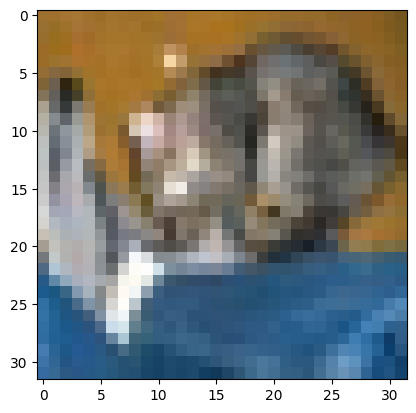

Proponents:


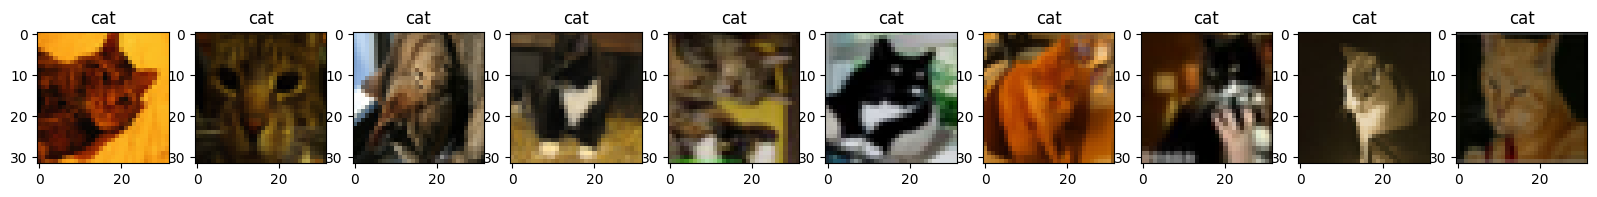

Opponents:


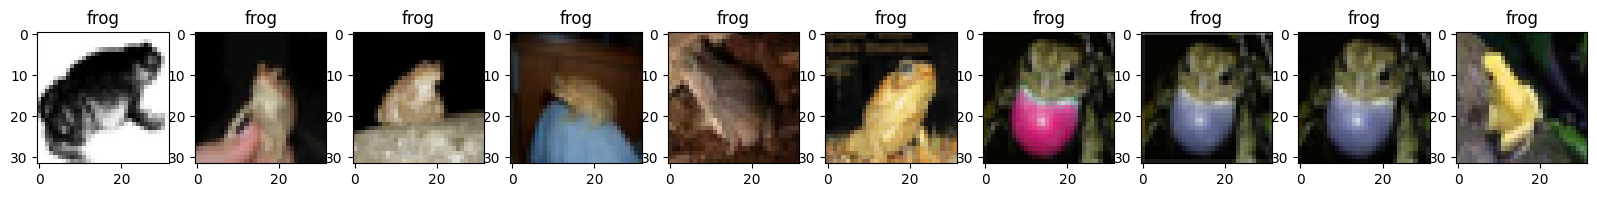

Test example:
True_class: ship
Predicted_class: ship
Predicted_prob: 0.8098457455635071


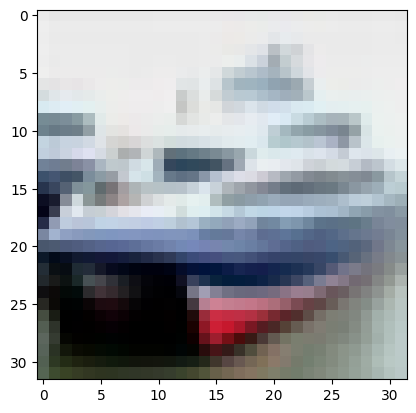

Proponents:


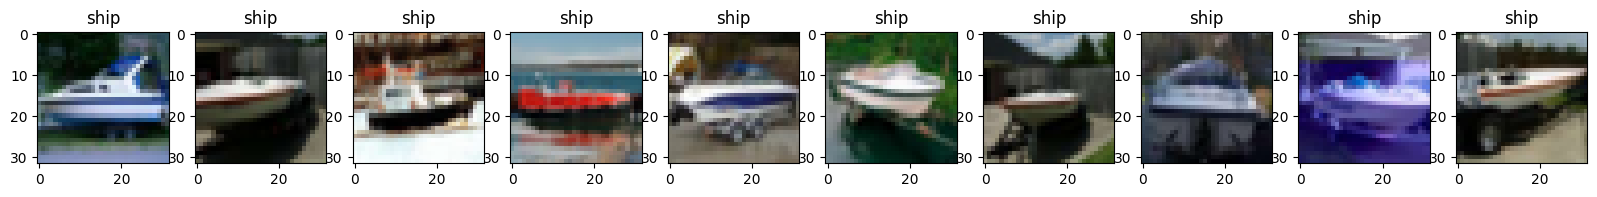

Opponents:


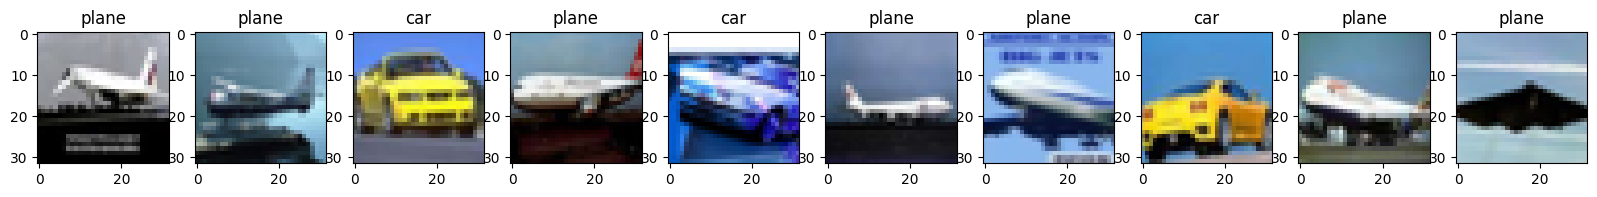

Test example:
True_class: ship
Predicted_class: ship
Predicted_prob: 0.8444550037384033


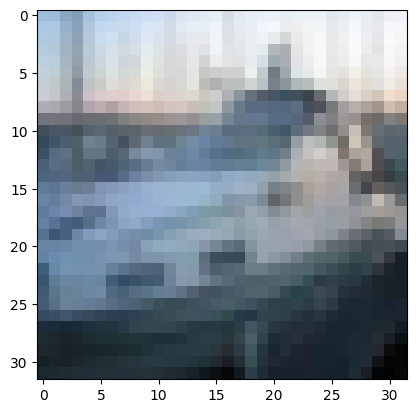

Proponents:


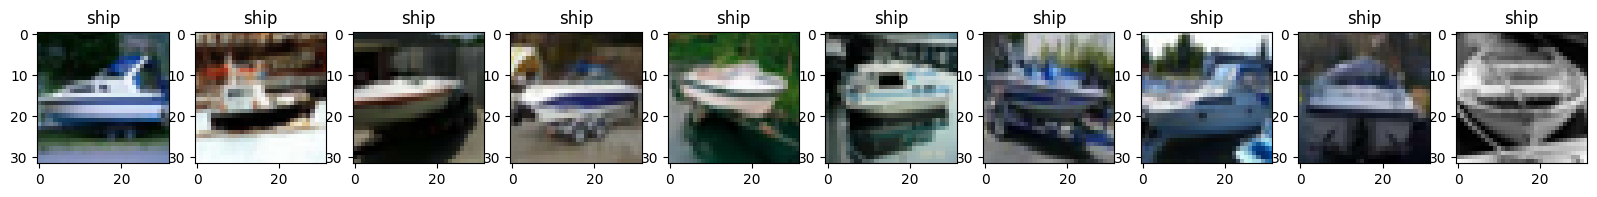

Opponents:


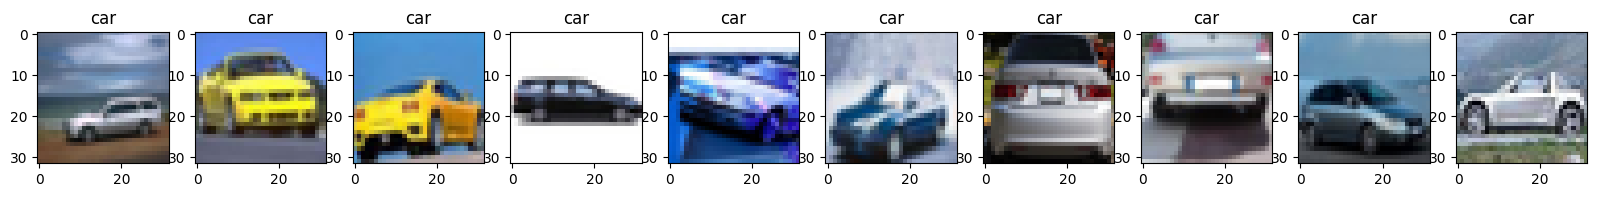

Test example:
True_class: plane
Predicted_class: ship
Predicted_prob: 0.6157054901123047


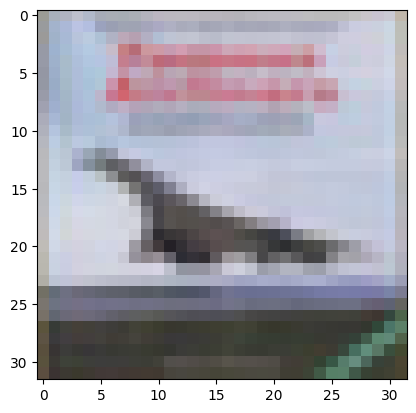

Proponents:


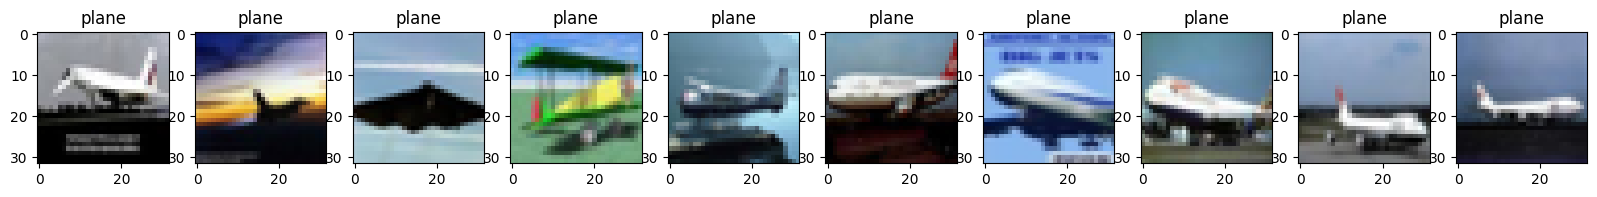

Opponents:


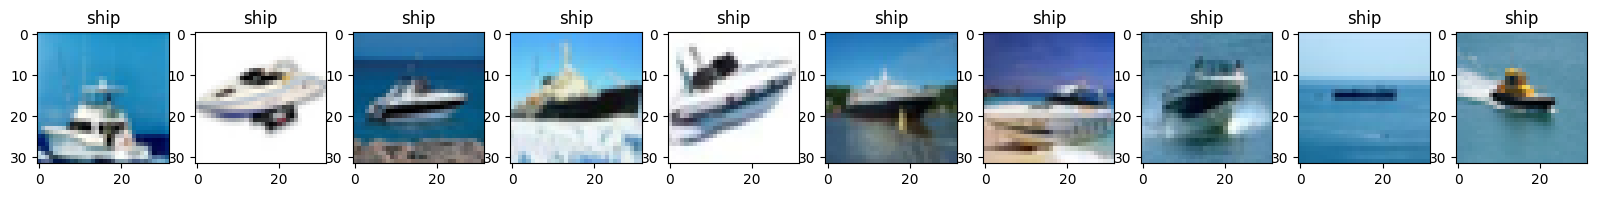

In [4]:
label_to_class=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
imshow_transform=lambda tensor_in_dataset:inverse_normalize(tensor_in_dataset.squeeze()).permute(1,2,0)
def display_test_example(example,true_label,predicted_label,predicted_prob,label_to_class):
    fig,ax=plt.subplots()
    print(f'True_class: {label_to_class[true_label]}\nPredicted_class: {label_to_class[predicted_label]}\nPredicted_prob: {predicted_prob}')
    ax.imshow(torch.clip(imshow_transform(example),0,1))
    plt.show()
def display_training_examples(examples,true_labels,label_to_class,figsize=(10,4)):
    fig=plt.figure(figsize=figsize)
    num_examples=len(examples)
    for i in range(num_examples):
        ax=fig.add_subplot(1,num_examples,i+1)
        ax.imshow(torch.clip(imshow_transform(examples[i]),0,1))
        ax.set_title(label_to_class[true_labels[i]])
    plt.show()
    return fig
def display_proponents_and_opponents(test_examples_batch,proponents_indices,opponents_indices,test_examples_true_labels,test_examples_predicted_labels,test_examples_predicted_probs):
    for (test_example,test_example_proponents,test_example_opponents,test_example_true_label,test_example_predicted_label,test_example_predicted_prob) in zip(test_examples_batch,proponents_indices,opponents_indices,test_examples_true_labels,test_examples_predicted_labels,test_examples_predicted_probs):
        print('Test example:')
        display_test_example(test_example,test_example_true_label,test_example_predicted_label,test_example_predicted_prob,label_to_class)
        print('Proponents:')
        test_example_proponents_tensors,test_example_proponents_labels=zip(*[correct_dataset[i] for i in test_example_proponents])
        display_training_examples(test_example_proponents_tensors,test_example_proponents_labels,label_to_class,figsize=(20,8))
        print('Opponents:')
        test_example_opponents_tensors,test_example_opponents_labels=zip(*[correct_dataset[i] for i in test_example_opponents])
        display_training_examples(test_example_opponents_tensors,test_example_opponents_labels,label_to_class,figsize=(20,8))
display_proponents_and_opponents(test_examples_features,proponents_indices,opponents_indices,test_examples_true_labels,test_examples_predicted_labels,test_examples_predicted_probs)

### Defining TracInCPFastRandProj instance

In [ ]:
start_time=datetime.datetime.now()
tracin_cp_fast_rand_proj=TracInCPFastRandProj(model=net,
                                              final_fc_layer=list(net.children())[-1],
                                              train_dataset=correct_dataset,
                                              checkpoints=correct_dataset_checkpoint_paths,
                                              checkpoints_load_func=checkpoints_load_func,
                                              loss_fn=nn.CrossEntropyLoss(reduction='sum'),
                                              batch_size=128,
                                              nearest_neighbors=AnnoyNearestNeighbors(num_trees=100),
                                              projection_dim=100)
total_minutes=(datetime.datetime.now()-start_time).total_seconds()/60
print(f'Performed pre-processing of a dataset of {len(correct_dataset)} examples in {total_minutes:.2f} minutes!')

/Users/I568200/.pyenv/versions/Environment/lib/python3.14/site-packages/captum/influence/_core/tracincp_fast_rand_proj.py:1049: UserWarning: WARNING: Using this implementation stores quantities related to the entire `train_dataset` in memory, and may results in running out of memory. If this happens, consider using `TracInCPFast` instead, for which each call to `influence` to compute influence scores or proponents will be slower, but may avoid running out of memory.
  warnings.warn(


Performed pre-processing of a dataset of 50000 examples in 0.99 minutes!


### Compute Proponents/Opponents Using TracInCPFastRandProj

In [6]:
k=10
start_time=datetime.datetime.now()
proponents_indices,proponents_influence_scores=tracin_cp_fast_rand_proj.influence((test_examples_features,test_examples_true_labels),k=k,proponents=True)
opponents_indices,opponents_influence_scores=tracin_cp_fast_rand_proj.influence((test_examples_features,test_examples_true_labels),k=k,proponents=False)
total_minutes=(datetime.datetime.now()-start_time).total_seconds()/60
print(f'Computed proponents/opponents over a dataset of {len(correct_dataset)} examples in {total_minutes:.2f} minutes!')

Computed proponents/opponents over a dataset of 50000 examples in 0.00 minutes!


Test example:
True_class: cat
Predicted_class: cat
Predicted_prob: 0.6040771007537842


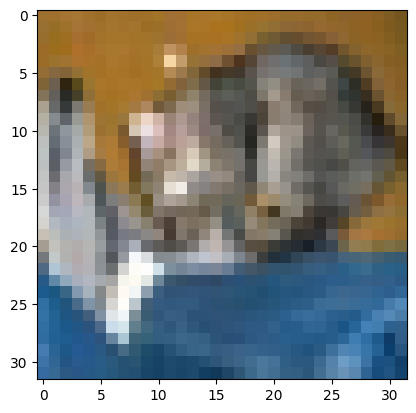

Proponents:


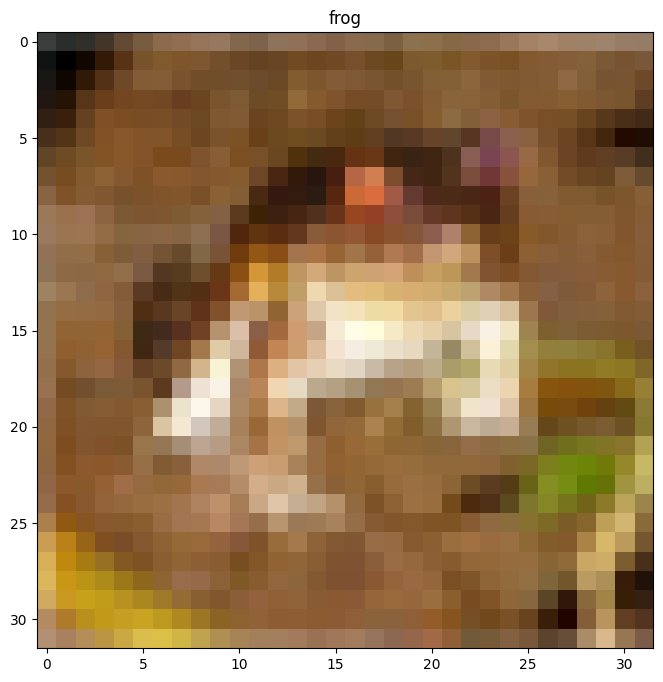

Opponents:


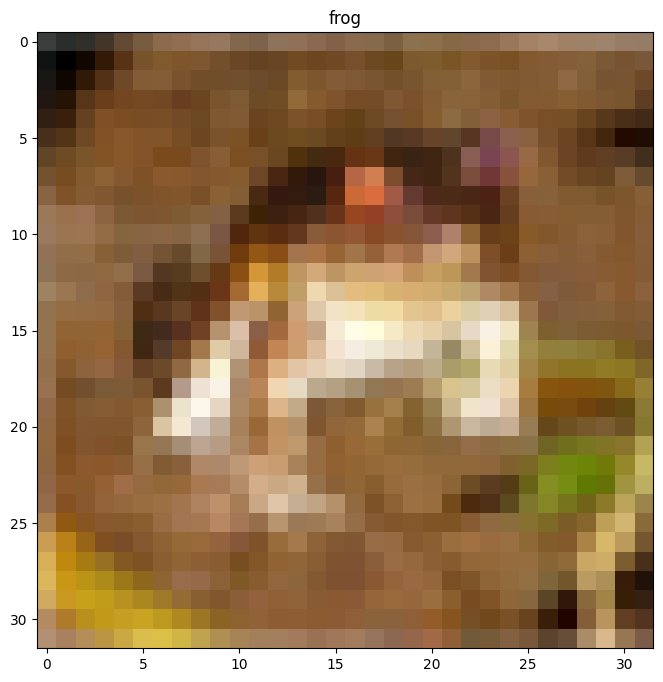

Test example:
True_class: ship
Predicted_class: ship
Predicted_prob: 0.8098457455635071


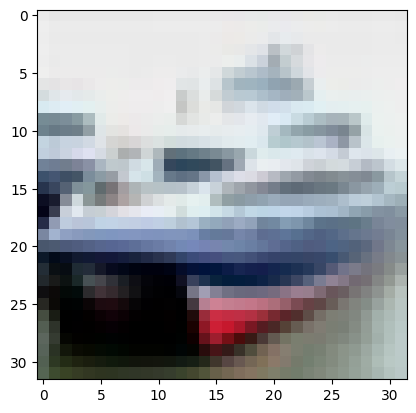

Proponents:


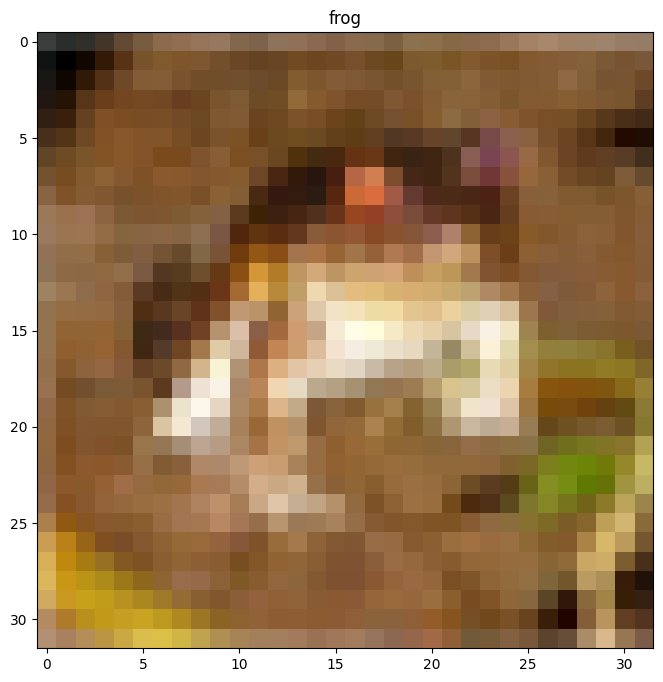

Opponents:


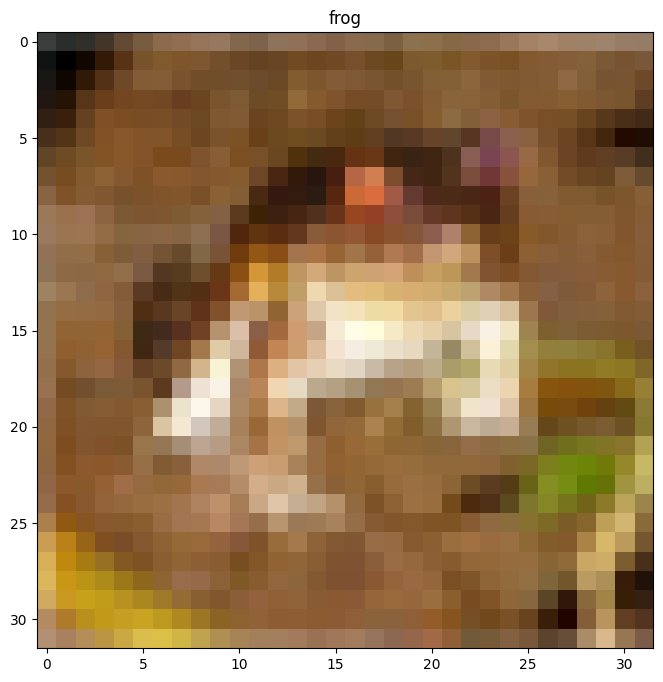

Test example:
True_class: ship
Predicted_class: ship
Predicted_prob: 0.8444550037384033


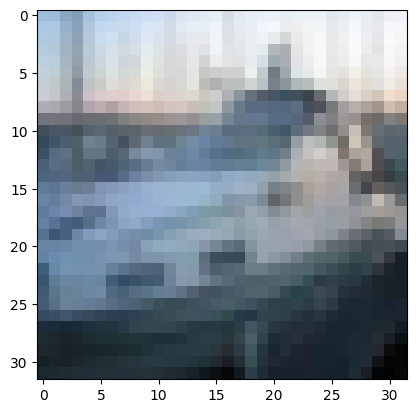

Proponents:


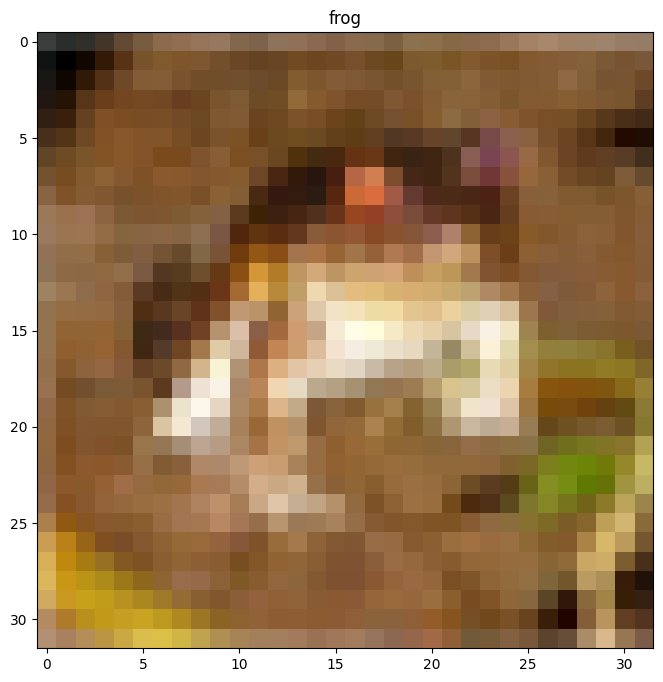

Opponents:


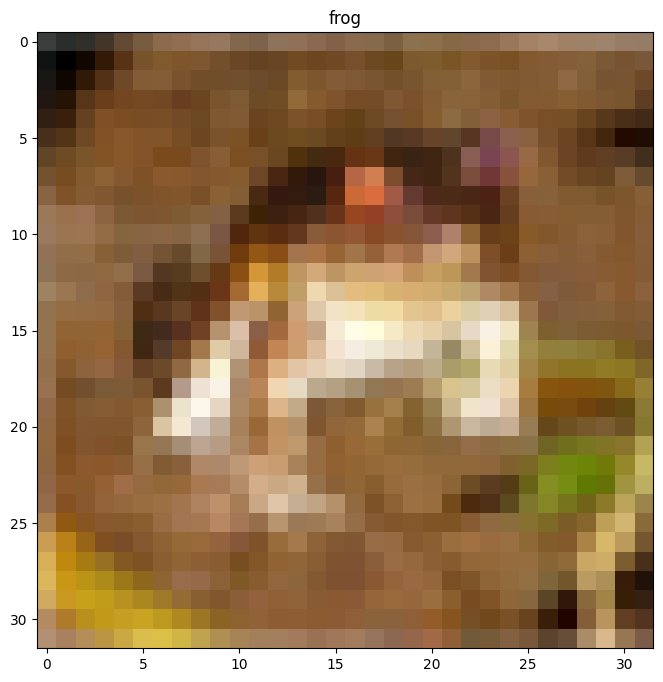

Test example:
True_class: plane
Predicted_class: ship
Predicted_prob: 0.6157054901123047


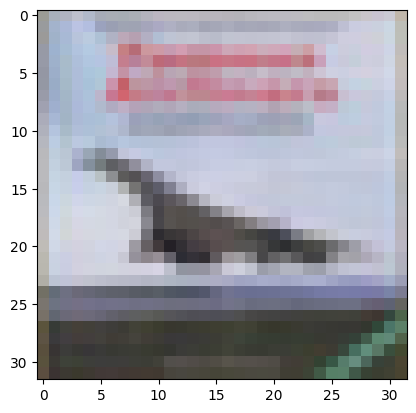

Proponents:


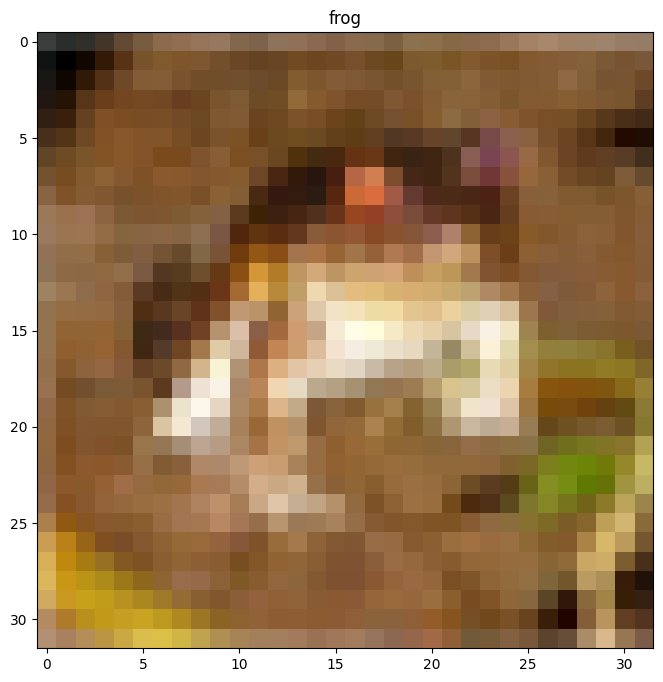

Opponents:


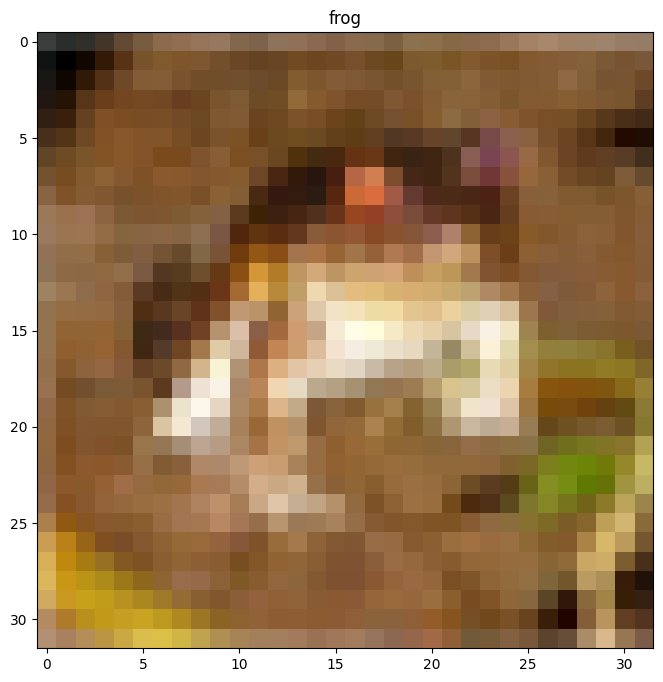

In [7]:
display_proponents_and_opponents(test_examples_features,proponents_indices,opponents_indices,test_examples_true_labels,test_examples_predicted_labels,test_examples_predicted_probs)

# Identifying Mislabelled Data
### Define mislabelled_dataset

In [8]:
net=Net()
correct_dataset_net=Net()
checkpoints_load_func(correct_dataset_net,correct_dataset_final_checkpoint)

1

In [9]:
start_time=datetime.datetime.now()
incorrect_labels=[]
correct_labels=[]
correct_dataset_dataloader=DataLoader(correct_dataset,batch_size=128,shuffle=False)
for i,(batch_features,batch_correct_labels) in enumerate(correct_dataset_dataloader):
    batch_predictions=torch.nn.functional.softmax(correct_dataset_net(batch_features),dim=1)
    batch_predictions[torch.arange(0,len(batch_predictions)),batch_correct_labels]=0
    batch_incorrect_labels=torch.argmax(batch_predictions,dim=1)
    incorrect_labels.append(batch_incorrect_labels)
    correct_labels.append(batch_correct_labels)
incorrect_labels=torch.cat(incorrect_labels)
correct_labels=torch.cat(correct_labels)
total_minutes=(datetime.datetime.now()-start_time).total_seconds()/60
print(f'Generated incorrect labels in {total_minutes:.2f} minutes!')

Generated incorrect labels in 0.07 minutes!


In [10]:
mislabelled_proportion=0.1
use_incorrect=torch.rand(len(incorrect_labels))<mislabelled_proportion
mislabelled_dataset_labels=(use_incorrect*incorrect_labels)+((~use_incorrect)*correct_labels)
class MislabelledDataset(Dataset):
    def __init__(self,correct_dataset:Dataset,mislabelled_dataset_labels:torch.Tensor):
        self.correct_dataset,self.mislabelled_dataset_labels=correct_dataset,mislabelled_dataset_labels
    def __getitem__(self,i):
        return self.correct_dataset[i][0],self.mislabelled_dataset_labels[i]
    def __len__(self):
        return len(self.correct_dataset)
mislabelled_dataset=MislabelledDataset(correct_dataset,mislabelled_dataset_labels)
_incorrect_dataset_labels=torch.Tensor([mislabelled_dataset[i][1] for i in range(len(mislabelled_dataset))])
_correct_dataset_labels=torch.Tensor([correct_dataset[i][1] for i in range(len(correct_dataset))])
is_mislabelled=_incorrect_dataset_labels!=_correct_dataset_labels
print(f"{100*torch.mean(is_mislabelled.float()):.2f}% of the labels in incorrect_dataset're mislabelled.")

10.01% of the labels in incorrect_dataset're mislabelled.


### Define Set Of Checkpoints

In [11]:
mislabelled_dataset_checkpoints_dir=os.path.join('checkpoints','cifar_10_mislabelled_dataset')
num_epochs=101
train(net,num_epochs,DataLoader(mislabelled_dataset,batch_size=128,shuffle=True),DataLoader(test_dataset,batch_size=128,shuffle=True),mislabelled_dataset_checkpoints_dir,save_every=20)

[1/100] Loss: 2.30
[1/200] Loss: 2.30
[1/300] Loss: 2.30
Accuracy of the network on test set at epoch 0: 12.73%
[2/100] Loss: 2.30
[2/200] Loss: 2.30
[2/300] Loss: 2.30
Accuracy of the network on test set at epoch 1: 14.97%
[3/100] Loss: 2.29
[3/200] Loss: 2.29
[3/300] Loss: 2.28
Accuracy of the network on test set at epoch 2: 17.72%
[4/100] Loss: 2.24
[4/200] Loss: 2.20
[4/300] Loss: 2.14
Accuracy of the network on test set at epoch 3: 26.24%
[5/100] Loss: 2.07
[5/200] Loss: 2.04
[5/300] Loss: 2.02
Accuracy of the network on test set at epoch 4: 29.57%
[6/100] Loss: 1.97
[6/200] Loss: 1.95
[6/300] Loss: 1.93
Accuracy of the network on test set at epoch 5: 32.8%
[7/100] Loss: 1.89
[7/200] Loss: 1.86
[7/300] Loss: 1.84
Accuracy of the network on test set at epoch 6: 36.19%
[8/100] Loss: 1.80
[8/200] Loss: 1.77
[8/300] Loss: 1.76
Accuracy of the network on test set at epoch 7: 38.27%
[9/100] Loss: 1.71
[9/200] Loss: 1.70
[9/300] Loss: 1.68
Accuracy of the network on test set at epoch 8: 

### Choosing TracInCP Algorithm To Use
### Defining TracInCPFast Instance
### Calculating Self Influence Scores

In [12]:
mislabelled_dataset_checkpoint_paths=glob.glob(os.path.join(mislabelled_dataset_checkpoints_dir,'*.pt'))
tracin_cp_fast=TracInCPFast(model=net,
                            final_fc_layer=list(net.children())[-1],
                            train_dataset=mislabelled_dataset,
                            checkpoints=mislabelled_dataset_checkpoint_paths,
                            checkpoints_load_func=checkpoints_load_func,
                            loss_fn=nn.CrossEntropyLoss(reduction='sum'),
                            batch_size=2048)
start_time=datetime.datetime.now()
self_influence_scores=tracin_cp_fast.self_influence()
total_minutes=(datetime.datetime.now()-start_time).total_seconds()/60
print(f'Computed self influence scores for {len(self_influence_scores)} examples in {total_minutes:.2f} minutes!')

Computed self influence scores for 50000 examples in 0.17 minutes!


### Evaluating Ability Of Self Influence Scores To Detect Mis-Labelled Data

/var/folders/x6/l9hz8mhn6yx8xs6134b0n1_h0000gn/T/ipykernel_40546/14844962.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


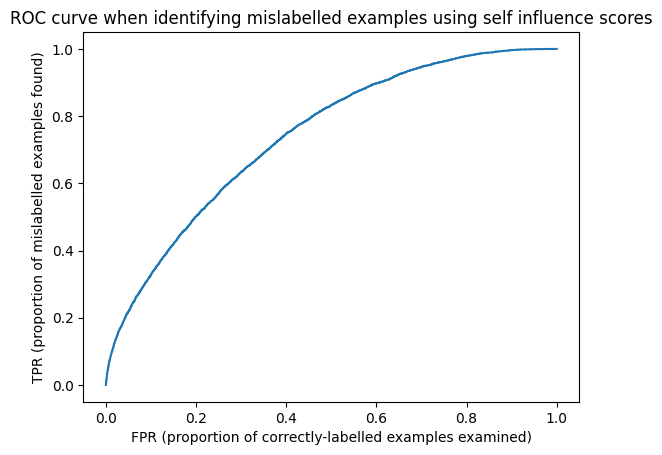

In [13]:
fpr,tpr,_=roc_curve(is_mislabelled,self_influence_scores)
fig,ax=plt.subplots()
ax.plot(fpr,tpr)
fontsize=10
ax.set_ylabel('TPR (proportion of mislabelled examples found)',fontsize=fontsize)
ax.set_xlabel('FPR (proportion of correctly-labelled examples examined)',fontsize=fontsize)
ax.set_title('ROC curve when identifying mislabelled examples using self influence scores')
fig.show()